# Part 2: Using LAMMPS to simulate a solid/electrolyte interface

Interfacial systems are extremely ubiquitous - from membranes in biological systems to electrode-electrolyte interfaces in batteries. In this part of the practical we will explore an interfacial system of relevance for numerous technological applications: a solution of NaCl in water in contact with graphene. Our goal is to learn how we can use a simulation trajectory to learn useful information about the structural and dynamic properties of this system.

You now have experience in running simulations with LAMMPS, and you should have generated a trajectory to analyse. Since it can take quite a while to converge certain properties (longer than you can do in the time of this practical on a few cores), in this section you will run your analysis on a longer trajectory (10 ns) that we provided for you here: `~/rds/rds-ljc-summerschool/Molecular_dynamics_4/traj.dcd`.

You can run the analysis as you would like -- you can for example explore the broad set of tools available from the _MDAnalysis_ python package, or you are free to write your own analysis scripts, use a different code or some combination of all of the above! 

If you would like to use MDAnalysis we have given you a head start in the cell below, loading the `Universe' with which you can use to do your analysis.

In [218]:
#Load libraries you might use
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import ase
import ase.io 
from ase import Atoms
from ase.visualize import view

import MDAnalysis as mda
from MDAnalysis.analysis.lineardensity import LinearDensity
import MDAnalysis.analysis.msd as msdmda
from MDAnalysis.analysis.distances import distance_array
from MDAnalysis.lib import distances
from MDAnalysis.analysis.base import AnalysisBase

# Some useful constants and unit conversions
m_na = 22.98976928 # molar mass
m_cl = 35.453
m_o = 15.999
cm_to_angstrom = 1e8
ps_to_s = 1e-12
NA = 6.02214076e23 # Avogadro's constant

data_path = './'
traj = 'traj.dcd'
top = 'init_nvt.xyz'

#create universe
u = mda.Universe(f'{data_path}/{top}', f'{data_path}/{traj}', format = 'LAMMPS')
atoms = u.select_atoms('all')   
set(atoms.types)
na = u.select_atoms('name Na')
cl = u.select_atoms('name Cl')
c = u.select_atoms('name C')
ox = u.select_atoms('name O')  

## How does the interface affect the electrolyte struture?

### Density profiles

The first question we want to explore is: what is the structure of the electrolyte at the interface? To address this, let's analyse the density profile of the electrolyte as a function of distance (in the z direction) from the interface. 

**Make a plot of the local density of the sodium ion, chloride, and water's oxygen atoms as a function of distance from the graphene.**

**Qs:** After what distance from the graphene does the water recover its bulk density?

**Qs:** How do the Na and Cl adsorption profiles compare? Is this behaviour what you expect physically?

### Water orientation

Following from the analysis of the overall structure of the electrolyte, it would also be interesting to understand how the interface affects the orientation of the waters.

To get you started, we've provided a function that gives you the positions of all the water molecules in the system. The function takes in an MDAnalysis universe and returns a three-dimensional numpy array of positions, where the dimensions correspond to (1) the atom in the water molecule (O, H, H) (2) the number of water molecules (500 in this case), and (3) the spatial direction (x, y, z).

In [254]:
def get_water_pos(u):
    oh_dist = distance_array(u.atoms.select_atoms('name O').positions,
                                 u.atoms.select_atoms('name H').positions,
                                 box=u.dimensions)

    idx = np.argpartition(oh_dist, 3, axis=-1)
    opos = u.atoms.select_atoms('name O').positions
    h1pos = u.atoms.select_atoms('name H')[idx[:,0]].positions
    h2pos = u.atoms.select_atoms('name H')[idx[:,1]].positions

    return np.array([opos, h1pos, h2pos])

Now, **write a function that computes the dipole orientation of the water ($\theta$) relative to the z direction** (see the image below).

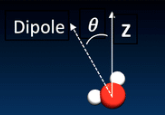

Finally, **make a plot of $cos(\theta)$ as a function of height (distance from the interface).** Incorporate the orientations of all water molecules over the whole trajectory.

**Qs:** Do the waters have a preferential orientation closer to the graphene compared to in bulk? 

## Electrolyte dynamics

Beyond structrual properties, we also want to understand the dynamics of the system and how tranpsort differs for the two ions and the water. To do so, let's compute the self-diffusion coefficient of the Na, Cl, and water. We recommend using the Einstein relation (recall from the lectures that $D = \frac{1}{2d} \frac{d}{dt} \langle r^2(t)\rangle$). 

**First, create a plot of the mean-squared displacement of each species vs time.** You can either write your own code to compute the mean-squared displacement or try out the msd module from MDAnalysis. Since the system is anisotropic in the z-direction, you should only compute the diffusion coefficients based on transport in the x- and y-directions. It may be useful to note that the snapshots stored in the provided trajectory file are collected every 1 ps. 

**Qs:** The trajectory we provided to you had *unwrapped* coordinates. What is the difference between unwrapped and wrapped coordinates, and which do we want to use to compute the MSD? What would your MSD plots have looked like with wrapped coordinates?

**Qs:** You may notice that the MSDs get noisier at long times, and that this noise is more pronounced for the ions than for the water molecules. Why do you think this is?

**Now, use the slope of the MSD plot you created to compute the diffusion coefficient for each species.** Report your answer in units if $cm^2/s$. As a sanity check, compare the order of magnitude of your diffusion coefficients to literature values for bulk water.

**Qs:** How sensitive is your result to the fitting regime/procedure you use (i.e. the range of times you use to make the linear fit)? What should you consider when choosing your fitting procedure to make your results reliable?

**Qs:** Which species (Na, Cl, and O) diffuse the fastest/slowest? Can you hypothesize why? 

## Final reflections

**Qs:** Do you think we are ready to publish our results? Can you think of some of the weaknesses in the simulations we have run above? For example you can think in terms of:

(a) the physical set-up. What are the constraints we impose on the system? Are these realistic? What would you instead do to improve the setup?

(b) the potential energy surface we use to represent the system. Is this the most accurate description of the system? Are there interactions that we are not accounting for with our current classical model?

(c) the analysis. Have we run the simulations long enough to get converged results? How could we get error estimates for each of the quantities we computed? 